### Operation based representation

A permutation is used to 

The paper by (Gen et al., 1994) use a operation based representation and also call it indirect. 

Survey of different representations classified in direct and indirect representations:
(Cheng et al., 1996)

Example problem for this notebook:


3 x 3 JSSP problem:

j1 2(1), 3(5), 1(2) \
j2 1(3), 2(3), 3(5) \
j3 1(2), 3(2), 2(4) 

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

n_machines = 3
n_jobs = 3
jssp_problem = np.array([
          # Technological sequence. Each row represents one job J. Each column represents the operation index.
          [[2, 3, 1],
           [1, 2, 3],
           [1, 3, 2]],
          # The second matrix contains the processing time
          [[1, 5, 2],
           [3, 3, 5],
           [2, 2, 4]]

])

First we need to create the permutation with m repetitions

In [75]:
indexes = np.random.permutation(n_machines*n_jobs)
j_rep_permutation = np.empty_like(indexes)

for i in range(len(indexes)):
    # For each element in the array, insert a job number in the j repetition permutation
    cur_index = indexes[i]
    j_rep_permutation[cur_index] = i % n_jobs

print(j_rep_permutation)

[0 2 1 1 0 1 2 2 0]


In [76]:
class Operation:
    def __init__(self, job, machine, duration, start):
        self.job = job
        self.machine = machine
        self.duration = duration
        self.start = start

In the following cell the operation based approach presented by (Bierwirth, 1995) is implemented. it produces semi-active schedules.

In [83]:
# The finished schedule is stored in the following list
operation_list = np.empty(n_machines*n_jobs, dtype=Operation)
# The machine and job time counters used to determine the start time for the next operations
m_start_t = np.zeros(n_machines)
j_start_t = np.zeros(n_jobs)
# machine sequence counter to determine which machine is next for each job
T_counter = np.zeros(n_machines, dtype=int)

for k in range(len(j_rep_permutation)):
    # For each job number in the permutation, shcedule it at the first possible time
    cur_job = j_rep_permutation[k]
    # Find the next machine in the technological sequence
    cur_machine = jssp_problem[0][cur_job][T_counter[cur_job]] - 1
    # First determine which machine the job should be 
    if m_start_t[cur_machine] >= j_start_t[cur_job]:
        cur_start = m_start_t[cur_machine]
    else:
        cur_start = j_start_t[cur_job]

    cur_duration = jssp_problem[1][cur_job][T_counter[cur_job]]
    m_start_t[cur_machine] = cur_start + cur_duration
    j_start_t[cur_job] = cur_start + cur_duration

    operation_list[k] = Operation(cur_job+1, cur_machine+1, cur_duration, cur_start)
    # Increment the mahcine counter
    T_counter[cur_job] += 1

Creating the dataframe of the solution

In [78]:
op_list = []
for op in operation_list:
    op_list.append({"Task" : "M" + str(op.machine), "start_time" : op.start, "stop_time" : op.start + op.duration, "operation" : "O_" + str(op.job) + "," + str(op.machine)})

df = pd.DataFrame(op_list)

Plotting gnatt chart for the solution

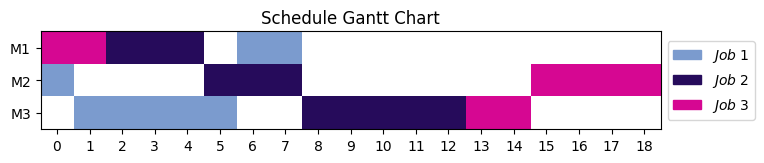

In [79]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
start_time = 0
stop_time = df["stop_time"].max()
n_rows = df["Task"].unique().shape[0]
color_dict = {i : np.random.randint(0, 256, 3) for i in range(1, n_rows+1)}
# Initiate all cells to white (255, 255, 255)
image = np.ones((n_rows, int(stop_time), 3), dtype=int) * 255
for operation in op_list:
    cur_job = int(operation["operation"][2])
    machine_number = int(operation["Task"][-1])-1
    image[machine_number][int(operation["start_time"]) : int(operation["stop_time"])][:] = color_dict[cur_job]

# Create color patches
handlers = []
for i, color in color_dict.items():
    handlers.append(mpatches.Patch(color=color/255, label=f'$Job\;{i}$'))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(handles=handlers, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("Schedule Gantt Chart")
ax.set_yticks([0,1,2])
ax.set_yticklabels(["M1", "M2", "M3"])

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

ax.imshow(image)
#plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.show()

In [80]:
df

,Task,start_time,stop_time,operation
0,M2,0.0,1.0,"O_1,2"
1,M1,0.0,2.0,"O_3,1"
2,M1,2.0,5.0,"O_2,1"
3,M2,5.0,8.0,"O_2,2"
4,M3,1.0,6.0,"O_1,3"
5,M3,8.0,13.0,"O_2,3"
6,M3,13.0,15.0,"O_3,3"
7,M2,15.0,19.0,"O_3,2"
8,M1,6.0,8.0,"O_1,1"


In [81]:
jssp_problem

array([[[2, 3, 1],
        [1, 2, 3],
        [1, 3, 2]],

       [[1, 5, 2],
        [3, 3, 5],
        [2, 2, 4]]])

Create the permutation with m repretitions

References:

* Gen, M., Tsujimura, Y., & Kubota, E. (1994). Solving job-shop scheduling problems by genetic algorithm. Proceedings of IEEE International Conference on Systems, Man and Cybernetics, 2, 1577–1582 vol.2. https://doi.org/10.1109/ICSMC.1994.400072

* Bierwirth, C. (1995). A generalized permutation approach to job shop scheduling with genetic algorithms. Operations-Research-Spektrum, 17(2), 87–92. https://doi.org/10.1007/BF01719250

* Cheng, R., Gen, M., & Tsujimura, Y. (1996). A tutorial survey of job-shop scheduling problems using genetic algorithms—I. representation. Computers & Industrial Engineering, 30(4), 983–997. https://doi.org/10.1016/0360-8352(96)00047-2
